# Errores en la determinación de la posición
## Ejemplo con 2 agentes
Posiciones iniciales
1. Agente 1 (1,1)
2. Agente 2 (5,1)

Consideraré que el agente 1 mide sin error y el agente 2 mide con error las posiciones

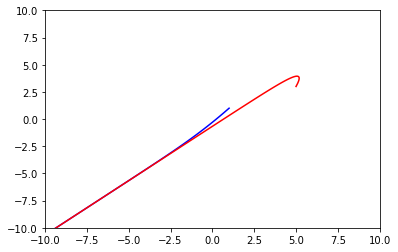

In [1]:
import RobotModels as rob
import numpy as np
import matplotlib.pyplot as plt
import graph_utils as graf
import time
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import robot_plot_utils as rpu

#Posiciones iniciales
pi=np.array([[1,1],[5,3]])
p=np.zeros([2,2])
#Formacion
zstar=np.array([-5,-5])
#Grafo
Z=np.array([1,2])
fig= plt.figure()
p=pi
a1=0.5
a2=1
h=0.1
n=100
p1=np.zeros([n,2])
p1[0,:]=pi[0,:]
p2=np.zeros([n,2])
p2[0,:]=pi[1,:]
p1dot=np.zeros([1,2])
p2dot=np.zeros([1,2])
 # style for plotting line
# set limit for x and y axis
axis =plt.axes(xlim=(-10,10),ylim=(-10,10))

agente1, = axis.plot([],[],c='b')
agente2, = axis.plot([],[],c='r')
def init():
    agente1.set_data([],[])
    agente2.set_data([],[])
    return agente1, agente2
    
for i in range(n-1):
    p1dot=-(a1*(p1[i,:]-p2[i,:])-zstar)
    x1dot,y1dot,theta1dot=rob.integrator_point_model(p1dot[0],p1dot[1])
    p1[i+1,0]=p1[i,0]+h*x1dot
    p1[i+1,1]=p1[i,1]+h*y1dot
    p2dot=-(a2*(p2[i,:]-p1[i,:])+zstar)
    x2dot,y2dot,theta2dot=rob.integrator_point_model(p2dot[0],p2dot[1])
    p2[i+1,0]=p2[i,0]+h*x2dot
    p2[i+1,1]=p2[i,1]+h*y2dot

x1, y1, x2, y2 = [], [], [], []

def animate(i):
    x1.append((p1[i,0]))
    y1.append((p1[i,1]))
    x2.append((p2[i,0]))
    y2.append((p2[i,1]))
    agente1.set_data(x1,y1)
    agente2.set_data(x2,y2)
    return (agente1, agente2)
    #axes.plot(x1,y1,color="blue")
    #axes.plot(x2,y2,color="red")

anim = FuncAnimation(fig=fig,func=animate,init_func=init,frames=100,interval=30,blit=True)
# converting to an html5 video 
videowriter = PillowWriter(fps=30)

anim.save("prueba.gif", writer=videowriter)
  
# draw the animation 
#display.display(html) 
plt.show()
plt.close() 

Vamos ahora a replicar el ejemplo del paper de Héctor con 9 agentes


[[0.54902358 0.52920753 0.68406331 1.24116031 1.13083403 0.83952961
  1.29824145 1.01228886 1.15344019]]
[[ 0.17055061 -0.07104981  0.06420421  0.16747695  0.06563128  0.10928418
  -0.13974972 -0.02200422  0.04479153]]


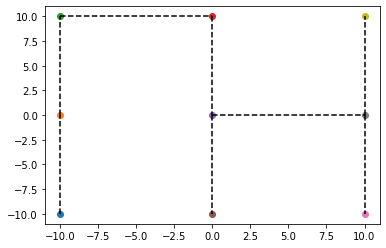

In [40]:
#Posiciones iniciales
pi=np.array([[-10,-10],[-10,0],[-10 ,10],[0,10],[0,0],[0,-10],[10,-10],[10,0],[10,10]])
p=np.zeros([2,9])
numnodos,m=np.shape(pi)
#Formacion
zstar=np.array([-5,-5])
#Grafo
Z=np.array([[1,2],[2,3],[3,4],[4,5],[5,6],[5,8],[8,7],[8,9]])
numarcos,m=np.shape(Z)
# Scale factors
var=0.5
a = 1+2*var*np.random.rand(1,9)-var*np.ones([1,9])
#a=np.ones([1,9])
print(a)
#Misalignments in radians
rm=10*np.pi/180
#rm=0
r=np.zeros([1,9])
r=2*rm*np.random.rand(1,9)-rm*np.ones([1,9])
print(r)
n,m= np.shape(pi)
for i in range(n):
    plt.plot(pi[i,0],pi[i,1],'o')

rpu.dibuja_grafo_2D(pi,Z)

In [41]:
m,n=np.shape(a)
Da=np.diag(a[0,:])
#print(Da)
j=0
k=0
DR=np.zeros([n*2,2*n])
for i in range(0,2*n,2):
    DR[j,i]=np.cos(r[0,k])
    DR[j,i+1]=-np.sin(r[0,k])
    DR[j+1,i]=np.sin(r[0,k])
    DR[j+1,i+1]=np.cos(r[0,k])
    j+=2
    k+=1


Construimos la matriz Dx $D_x=D_a \otimes I_m \dot D_R$

L: 
[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  3. -1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  3. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.]]
10000
[-103.65241964  -26.17845623 -104.24326483  -17.0319121  -106.59685025
   -8.38337337  -96.33407452  -14.63280212  -93.9333357   -28.4484333
  -92.17155447  -44.77926566  -82.72895789  -34.32431951  -83.24903062
  -26.56191777  -82.17836473  -17.21762479]


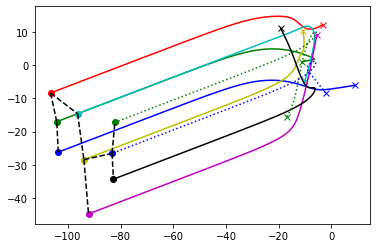

In [39]:
Im=np.eye(2)
Da_bar=np.kron(Da,Im)
i=n*4
#print(np.shape(DR))
#print(Dr)
Dx=np.dot(Da_bar,DR)
#print(np.shape(Dx))
pesos=np.ones([numnodos,numnodos])
L=graf.matriz_laplaciana(Z,pesos,numnodos,numarcos)
print("L: ")
print(L)
Lbar=np.kron(L,Im)
M=-np.dot(Dx,Lbar)
p=np.zeros([2*n,1])
#print(np.shape(p))
rm=20
pstar=graf.stack(pi)
t=0
tf=100
dt=0.01
nptos=(int)((tf-t)/dt)
print(nptos)
fig2 =plt.figure()
p=2*rm*np.random.rand(2*n)-rm*np.ones(2*n)
posiciones=np.zeros([2*n , nptos])
k=0
Lps=np.dot(Lbar,pstar)
#print(Lps)
#Revisar: Los 5 primeros salen bien pero el resto no
for k in range(nptos):
    pdot=np.dot(M,p)+Lps
    for i in range(0,2*n,2):
        xdot,ydot,thetadot=rob.integrator_point_model(pdot[i],pdot[i+1])
        p[i]+=dt*xdot
        p[i+1]+=dt*ydot
    posiciones[:,k]=p[:]
    t+=dt
print(posiciones[:,k])
colors_f=['bo','go','ro','co','yo','mo','ko','bo','go']
colors_i=['bx','gx','rx','cx','yx','mx','kx','bx','gx']
colors_l=['b','g','r','c','y','m','k','b:','g:']
Z=np.array([[1,2],[2,3],[3,4],[4,5],[5,6],[5,8],[8,7],[8,9]])
j=0
for i in range(n):
    plt.plot(posiciones[j,0],posiciones[j+1,0],colors_i[i])
    plt.plot(posiciones[j,nptos-1],posiciones[j+1,nptos-1],colors_f[i])
    plt.plot(posiciones[j,:],posiciones[j+1,:],colors_l[i])
    j=j+2
#rpu.dibuja_grafo_2D(pi,Z)
pfs=np.zeros([2*n,1])
pfs[:,0]=posiciones[:,nptos-1]
#print(pfs)
pf=graf.unstack(pfs,2)
#print(pf)
rpu.dibuja_grafo_2D(pf,Z)
plt.show()